In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from tqdm.autonotebook import tqdm
import time
from IPython.display import clear_output

import torch
import torch.nn.functional as F
import torchvision.transforms as tvt
from torchvision.models.resnet import ResNet, BasicBlock
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

In [2]:
def plot_loss(ax, tr_loss, te_loss):
    ax.plot(tr_loss)
    ax.plot(te_loss)
    ax.set_title('Loss')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.grid()

def plot_confusion_matrix(ax, y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [56]:
def apply_color(images, labels, biased=False):
    colors = np.array(
        [[230, 25, 75],
        [245, 130, 48],
        [255, 225, 25],
        [250, 190, 190],
        [0, 130, 200],
        [230, 190, 255],
        [240, 50, 230],
        [70, 240, 240],
        [60, 180, 75],
        [170, 110, 40]])
    
    if biased:
        # assign a random probability to each color, for each class
        # each class has a predilection to one color, with a smaller probability of assuming others
        bias = np.eye(10) + np.random.randint(0,3,(10,10)) / 300
    else:
        # for test samples each color should be equally likely
        bias = np.ones((10,10))
        
    # make sure bias sums to 1 across its rows
    bias = bias / bias.sum(axis=1,keepdims=1)
    
    color_labels = np.zeros(labels.shape, dtype = np.int64)
    i = 0
    for im, lb in zip(images, labels):
        # get the color probabilities for this class
        color_probs = bias[lb]
        color_index = np.random.choice(np.arange(10), p=color_probs)
        color_labels[i] = color_index
        i = i + 1
        color = colors[color_index]

        for i in range(3):
            im[i,:,:] *= color[i] / 255

    color_labels = torch.tensor(color_labels)
    return images, color_labels

In [20]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, nfilt_in, nfilt_out, stride):
        super(ResidualBlock, self).__init__()
        self.conv_s = torch.nn.Conv2d(nfilt_in, nfilt_out, kernel_size=1, stride=stride, padding=0, bias=False)
        self.bnorm_i = torch.nn.BatchNorm2d(nfilt_in)
        self.conv_a = torch.nn.Conv2d(nfilt_in, nfilt_out, kernel_size=3, stride=1, padding=1, bias=False)
        self.bnorm_a = torch.nn.BatchNorm2d(nfilt_out)
        self.conv_b = torch.nn.Conv2d(nfilt_out, nfilt_out, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bnorm_b = torch.nn.BatchNorm2d(nfilt_out)
        self.bnorm_o = torch.nn.BatchNorm2d(nfilt_out)
        
    def forward(self, x):
        shortcut = self.conv_s(x)
        
        x = self.bnorm_i(x)
        x = self.conv_a(x)
        x = F.leaky_relu(x)
        x = self.bnorm_a(x)
        x = self.conv_b(x)
        x = F.leaky_relu(x)
        x = self.bnorm_b(x)
        
        x = x + shortcut
        x = self.bnorm_o(x)
        x = F.leaky_relu(x)
        return x

class Resnet(torch.nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        self.res_block_0_0 = ResidualBlock(3, 16, 1)
        self.res_block_0_1 = ResidualBlock(16, 16, 1)
        self.res_block_0_2 = ResidualBlock(16, 16, 1)
        self.res_block_1_0 = ResidualBlock(16, 32, 2)
        self.res_block_1_1 = ResidualBlock(32, 32, 1)
        self.res_block_2_0 = ResidualBlock(32, 64, 2)
        self.res_block_2_1 = ResidualBlock(64, 64, 1)
        self.conv_o = torch.nn.Conv2d(64, 10, kernel_size=3, stride=1, padding=1, bias=False)

    def forward(self, x):
        x = self.res_block_0_0(x)
        x = self.res_block_0_1(x)
        x = self.res_block_0_2(x)
        x = self.res_block_1_0(x)
        x = self.res_block_1_1(x)
        x = self.res_block_2_0(x)
        x = self.res_block_2_1(x)

        x = self.conv_o(x)        
        
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(-1, 10)
        probas = F.softmax(x, dim=1)
        return x, probas
    
class DigitClassifier():
    def __init__(self):
        self.model = Resnet()
        self.model.cuda()
        
        self.loss = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        
    def train_on_batch(self, loader, colortype):
        avg_loss = 0.0
        self.model.train()
        
        data_count = len(loader.dataset)
        for i, data in enumerate(loader, 0):
            mb_inputs, mb_labels = data
            if colortype == 'biased':
                mb_inputs, mb_colors = apply_color(mb_inputs, mb_labels, True)
            elif colortype == 'unbiased':
                mb_inputs, mb_colors = apply_color(mb_inputs, mb_labels, False)
            
            mb_inputs = mb_inputs.cuda()
            mb_labels = mb_labels.cuda()
            self.optimizer.zero_grad()

            mb_output, _ = self.model(mb_inputs)
            mb_loss = self.loss(mb_output, mb_labels)
            mb_loss.backward()
            self.optimizer.step()
            
            avg_loss += (mb_loss.item() / data_count)
        return avg_loss
    
    def run_on_batch(self, loader, colortype):
        avg_loss = 0.0
        self.model.eval()

        data_count = len(loader.dataset)
        mb_sz = tr_loader.batch_size
        output = np.zeros((data_count, 10), dtype=float)
        for i, data in enumerate(loader, 0):
            mb_inputs, mb_labels = data
            if colortype == 'biased':
                mb_inputs, mb_colors = apply_color(mb_inputs, mb_labels, True)
            elif colortype == 'unbiased':
                mb_inputs, mb_colors = apply_color(mb_inputs, mb_labels, False)
                
            mb_inputs = mb_inputs.cuda()
            mb_labels = mb_labels.cuda()
            
            mb_output, mb_probas = self.model(mb_inputs)
            mb_loss = self.loss(mb_output, mb_labels)
            
            ix_s = i*mb_sz
            ix_e = ix_s + mb_inputs.shape[0]
            output[ix_s:ix_e] = mb_probas.data.cpu()
            avg_loss += (mb_loss.item() / data_count)
        
        return output, avg_loss

In [21]:
# create the data loader
transform = tvt.Compose([
    # convert from PIL to tensor
    tvt.ToTensor(), 
    # convert from gray to rgb
    tvt.Lambda(lambda x: x.repeat(3, 1, 1) )
])
mnist = datasets.MNIST(root='E:/data/datasets/mnist', train=True, download=True, transform=transform)
tr_loader = DataLoader(mnist, batch_size=32, shuffle=True)
mnist = datasets.MNIST(root='E:/data/datasets/mnist', train=False, download=True, transform=transform)
te_loader = DataLoader(mnist, batch_size=32, shuffle=False)

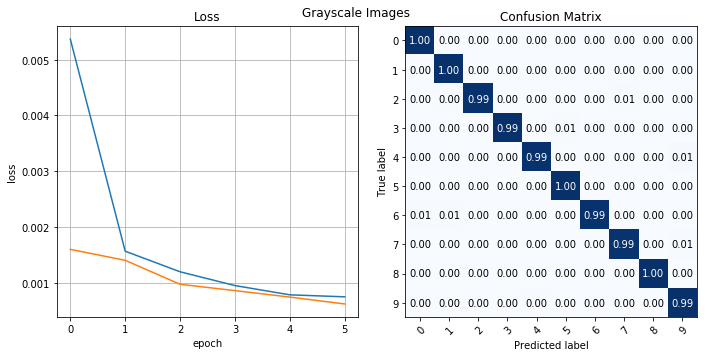

In [9]:
dc = DigitClassifier()

epochs = 6
loss_plot = np.zeros((epochs, 2))

for e in range(epochs):
    tr_loss = dc.train_on_batch(tr_loader, None)
    output, te_loss = dc.run_on_batch(te_loader, None)

    loss_plot[e,0] = tr_loss
    loss_plot[e,1] = te_loss
    
    pred = np.argmax(output, axis=1)
    labels = np.array(te_loader.dataset.test_labels)
    gray_accuracy = sum(pred == labels) / len(pred)
    
    clear_output()
    fig, axes = plt.subplots(1, 2, num=1, figsize=(10,5))
    fig.suptitle('Grayscale Images')
    plot_loss(axes[0], loss_plot[:,0], loss_plot[:,1])
    plot_confusion_matrix(axes[1], labels, pred, np.arange(10), normalize=True, title='Confusion Matrix')
    
    plt.pause(0.05)
    plt.show()

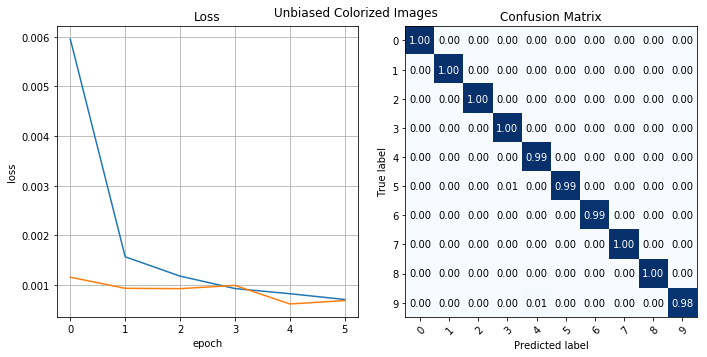

In [26]:
dc = DigitClassifier()

epochs = 6
loss_plot = np.zeros((epochs, 2))

for e in range(epochs):
    tr_loss = dc.train_on_batch(tr_loader, 'unbiased')
    output, te_loss = dc.run_on_batch(te_loader, 'unbiased')

    loss_plot[e,0] = tr_loss
    loss_plot[e,1] = te_loss
    
    pred = np.argmax(output, axis=1)
    labels = np.array(te_loader.dataset.test_labels)
    unbiased_accuracy = sum(pred == labels) / len(pred)
    
    clear_output()
    fig, axes = plt.subplots(1, 2, num=1, figsize=(10,5))
    fig.suptitle('Unbiased Colorized Images')
    plot_loss(axes[0], loss_plot[:,0], loss_plot[:,1])
    plot_confusion_matrix(axes[1], labels, pred, np.arange(10), normalize=True, title='Confusion Matrix')
    
    plt.pause(0.05)
    plt.show()

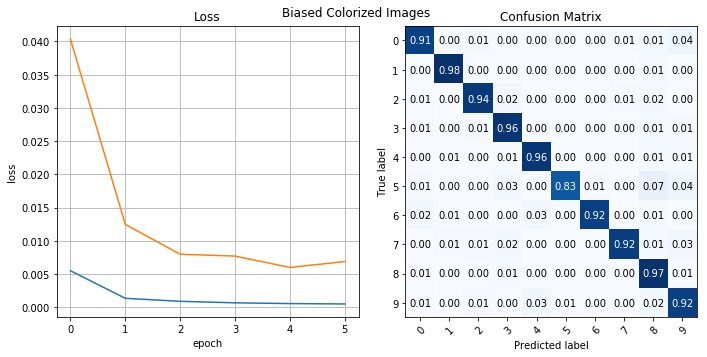

In [38]:
dc = DigitClassifier()

epochs = 6
loss_plot = np.zeros((epochs, 2))

for e in range(epochs):
    tr_loss = dc.train_on_batch(tr_loader, 'biased')
    output, te_loss = dc.run_on_batch(te_loader, 'unbiased')

    loss_plot[e,0] = tr_loss
    loss_plot[e,1] = te_loss
    
    pred = np.argmax(output, axis=1)
    labels = np.array(te_loader.dataset.test_labels)
    biased_accuracy = sum(pred == labels) / len(pred)
    
    clear_output()
    fig, axes = plt.subplots(1, 2, num=1, figsize=(10,5))
    fig.suptitle('Biased Colorized Images')
    plot_loss(axes[0], loss_plot[:,0], loss_plot[:,1])
    plot_confusion_matrix(axes[1], labels, pred, np.arange(10), normalize=True, title='Confusion Matrix')
    
    plt.pause(0.05)
    plt.show()

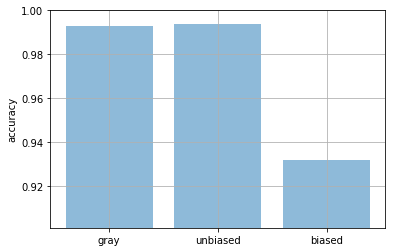

In [42]:
categories = ('gray', 'unbiased', 'biased')
accuracy = (gray_accuracy, unbiased_accuracy, biased_accuracy)
plt.bar(categories, accuracy, align='center', alpha=0.5)
hi = np.max(accuracy)
lo = np.min(accuracy)
plt.ylim([lo - 0.5 * (hi - lo), 1]);
plt.ylabel('accuracy')
plt.grid()

In [74]:
# I've basically split the resnet from the previous example into 2 parts.
class Embedder(torch.nn.Module):
    def __init__(self):
        super(Embedder, self).__init__()
        self.res_block_0_0 = ResidualBlock(3, 16, 1)
        self.res_block_0_1 = ResidualBlock(16, 16, 1)
        self.res_block_0_2 = ResidualBlock(16, 16, 1)
        self.res_block_1_0 = ResidualBlock(16, 32, 2)
        self.res_block_1_1 = ResidualBlock(32, 32, 1)

    def forward(self, x):
        x = self.res_block_0_0(x)
        x = self.res_block_0_1(x)
        x = self.res_block_0_2(x)
        x = self.res_block_1_0(x)
        x = self.res_block_1_1(x)
        return x
    
# just to keep the code simpler, I'll use the same class for both the label predictor, g(f(x)),
# and the bias predictor, h(f(x))
class Classifier(torch.nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.res_block_2_0 = ResidualBlock(32, 64, 2)
        self.res_block_2_1 = ResidualBlock(64, 64, 1)
        self.conv_o = torch.nn.Conv2d(64, 10, kernel_size=3, stride=1, padding=1, bias=False)

    def forward(self, x):
        x = self.res_block_2_0(x)
        x = self.res_block_2_1(x)
        x = self.conv_o(x)        
        
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(-1, 10)
        probas = F.softmax(x, dim=1)
        return x, probas
    
class BiasedDigitClassifier():
    def __init__(self):
        # embedding generator
        self.f = Embedder()
        self.f.cuda()
        # label predictor
        self.g = Classifier()
        self.g.cuda()
        # bias predictor
        self.h = Classifier()
        self.h.cuda()
        
        # controls the strength of bias regularization
        self.lm = 1e-2
        self.loss = torch.nn.CrossEntropyLoss()
        # optimizer for the feature embedder f(x) and label preditor g(f(x))
        params = list(self.f.parameters()) + list(self.g.parameters())
        self.optimizer_g = torch.optim.Adam(params, lr=1e-3)
        # optimizer for the bias predictor
        self.optimizer_h = torch.optim.Adam(self.h.parameters(), lr=1e-3)
        
    def train_on_batch(self, loader, colortype):
        avg_loss_g = 0.0
        avg_loss_h = 0.0
        # set phasors to train
        self.f.train()
        self.g.train()
        self.h.train()
        
        data_count = len(loader.dataset)
        for i, data in enumerate(loader, 0):
            mb_inputs, mb_labels = data
            if colortype == 'biased':
                mb_inputs, mb_colors = apply_color(mb_inputs, mb_labels, True)
            else:
                mb_inputs, mb_colors = apply_color(mb_inputs, mb_labels, False)
            
            mb_inputs = mb_inputs.cuda()
            mb_labels = mb_labels.cuda()
            mb_colors = mb_colors.cuda()
            
            self.optimizer_g.zero_grad()
            self.optimizer_h.zero_grad()
            
            # compute the embedding and predict the bias
            mb_feature = self.f(mb_inputs)
            mb_output_h, _ = self.h(mb_feature)
            # compute bias predictor loss, and update h
            mb_loss_h = self.loss(mb_output_h, mb_colors)
            mb_loss_h.backward()
            self.optimizer_h.step()
            avg_loss_h += (mb_loss_h.item() / data_count)
            
            self.optimizer_g.zero_grad()
            self.optimizer_h.zero_grad()
            
            # predict the bias again, using the updated h
            # then compute the mutial information loss
            mb_feature = self.f(mb_inputs)
            _, mb_probas_h = self.h(mb_feature)
            # the point of this magic loss function is basically to get h(f(x)) to produce a uniform distribution.
            # minimizing the entropy of its output will accomplish this
            mb_loss_mi = torch.mean(torch.sum(mb_probas_h * torch.log(mb_probas_h), 1))
            
            # predict the label, and then compute total loss
            mb_output_g, _ = self.g(mb_feature)
            mb_loss_g = self.loss(mb_output_g, mb_labels)
            mb_loss = mb_loss_g + self.lm * mb_loss_mi
            mb_loss.backward()
            self.optimizer_g.step()
            avg_loss_g += (mb_loss_g.item() / data_count)
            
        return avg_loss_g, avg_loss_h
    
    def run_on_batch(self, loader, colortype):
        avg_loss_g = 0.0
        avg_loss_h = 0.0
        self.f.eval()
        self.g.eval()
        self.h.eval()

        data_count = len(loader.dataset)
        mb_sz = tr_loader.batch_size
        output_g = np.zeros((data_count, 10), dtype=float)
        output_h = np.zeros((data_count, 10), dtype=float)
        for i, data in enumerate(loader, 0):
            mb_inputs, mb_labels = data
            if colortype == 'biased':
                mb_inputs, mb_colors = apply_color(mb_inputs, mb_labels, True)
            else:
                mb_inputs, mb_colors = apply_color(mb_inputs, mb_labels, False)
                
            mb_inputs = mb_inputs.cuda()
            mb_labels = mb_labels.cuda()
            mb_colors = mb_colors.cuda()
            
            # compute f(x)
            mb_feature = self.f(mb_inputs)
            # evaluate g(f(x))
            mb_output_g, mb_probas_g = self.g(mb_feature)
            mb_loss_g = self.loss(mb_output_g, mb_labels)
            # evaluate h(f(x))
            mb_output_h, mb_probas_h = self.h(mb_feature)
            mb_loss_h = self.loss(mb_output_h, mb_colors)
            
            ix_s = i*mb_sz
            ix_e = ix_s + mb_inputs.shape[0]
            output_g[ix_s:ix_e] = mb_probas_g.data.cpu()
            avg_loss_g += (mb_loss_g.item() / data_count)
            
            output_h[ix_s:ix_e] = mb_probas_h.data.cpu()
            avg_loss_h += (mb_loss_h.item() / data_count)
            
        return output_g, avg_loss_g, output_h, avg_loss_h

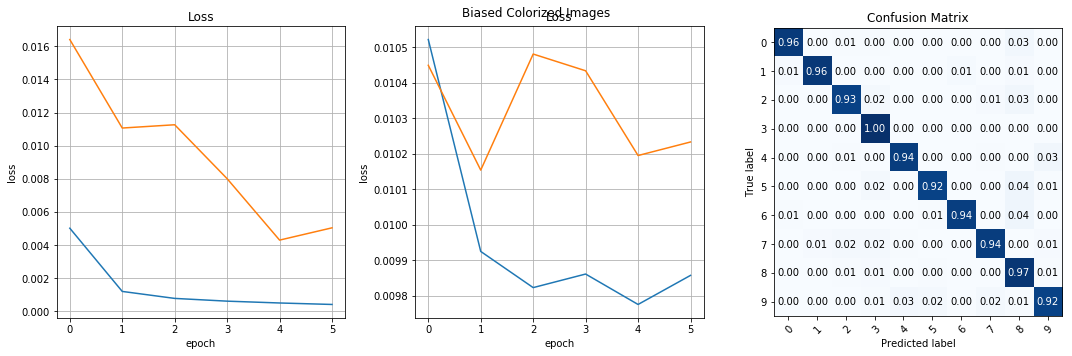

In [75]:
dc = BiasedDigitClassifier()

epochs = 6
loss_plot_g = np.zeros((epochs, 2))
loss_plot_h = np.zeros((epochs, 2))

for e in range(epochs):
    tr_loss_g, tr_loss_h = dc.train_on_batch(tr_loader, 'biased')
    output_g, te_loss_g, output_h, te_loss_h = dc.run_on_batch(te_loader, 'unbiased')

    loss_plot_g[e,0] = tr_loss_g
    loss_plot_g[e,1] = te_loss_g
    loss_plot_h[e,0] = tr_loss_h
    loss_plot_h[e,1] = te_loss_h
    
    pred = np.argmax(output_g, axis=1)
    labels = np.array(te_loader.dataset.test_labels)
    fixed_accuracy = sum(pred == labels) / len(pred)
    
    clear_output()
    fig, axes = plt.subplots(1, 3, num=1, figsize=(15,5))
    fig.suptitle('Biased Colorized Images')
    plot_loss(axes[0], loss_plot_g[:,0], loss_plot_g[:,1])
    plot_loss(axes[1], loss_plot_h[:,0], loss_plot_h[:,1])
    plot_confusion_matrix(axes[2], labels, pred, np.arange(10), normalize=True, title='Confusion Matrix')
    
    plt.pause(0.05)
    plt.show()

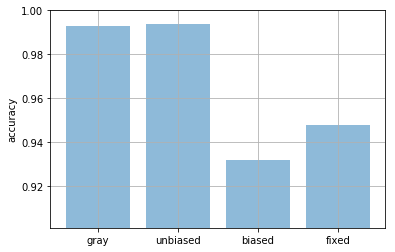

In [76]:
categories = ('gray', 'unbiased', 'biased', 'fixed')
accuracy = (gray_accuracy, unbiased_accuracy, biased_accuracy, fixed_accuracy)
plt.bar(categories, accuracy, align='center', alpha=0.5)
hi = np.max(accuracy)
lo = np.min(accuracy)
plt.ylim([lo - 0.5 * (hi - lo), 1]);
plt.ylabel('accuracy')
plt.grid()